Generating charmm system in vacuum
nnpops CUDA
platform='CUDA'
env='vacuum'
ml_atoms=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
/data/shared/software/python_env/anaconda3/envs/rew/lib/python3.9/site-packages/torchani/resources/
converting pickle file ...
Number of samples loaded: 4400


100%|██████████| 4400/4400 [00:09<00:00, 457.48it/s]


#-----------------------------------------#
Free energy difference: -940543.719906905
Free energy uncertainty: 0.07795397086089961
#-----------------------------------------#
FEP
#####################################################
# ------------------- FEP ---------------------------
#####################################################
Performing bidirectional protocol ...
Instantanious switching: dE will be calculated


100%|██████████| 5000/5000 [00:34<00:00, 144.47it/s]


Instantanious switching: dE will be calculated


100%|██████████| 5000/5000 [00:34<00:00, 146.25it/s]


#--------------- SUMMARY ---------------#
Zwanzig's equation (from mm to qml): {'Delta_f': -940542.5312004925, 'dDelta_f': 0.2749895166080587}
Zwanzig's equation (from qml to mm): {'Delta_f': 940546.5369358028, 'dDelta_f': 0.26964733696072973}
Zwanzig's equation bidirectional: {'Delta_f': -940544.3209516595, 'dDelta_f': 0.13855362730591822}
Jarzynski's equation (from mm to qml): {'Delta_f': -940545.6405343976, 'dDelta_f': 0.1823943619678441}
Jarzynski's equation (from qml to mm): {'Delta_f': 940543.8016212193, 'dDelta_f': 0.030675814922736144}
Crooks' equation: {'Delta_f': -940543.8412822594, 'dDelta_f': 0.027185758781778067}
Equilibrium free energy: -940543.719906905+/-0.07795397086089961
#--------------------------------------#
#################
[-940543.719906905, -940543.8412822594, -940545.6405343976, -940544.3209516595, -940542.5312004925]


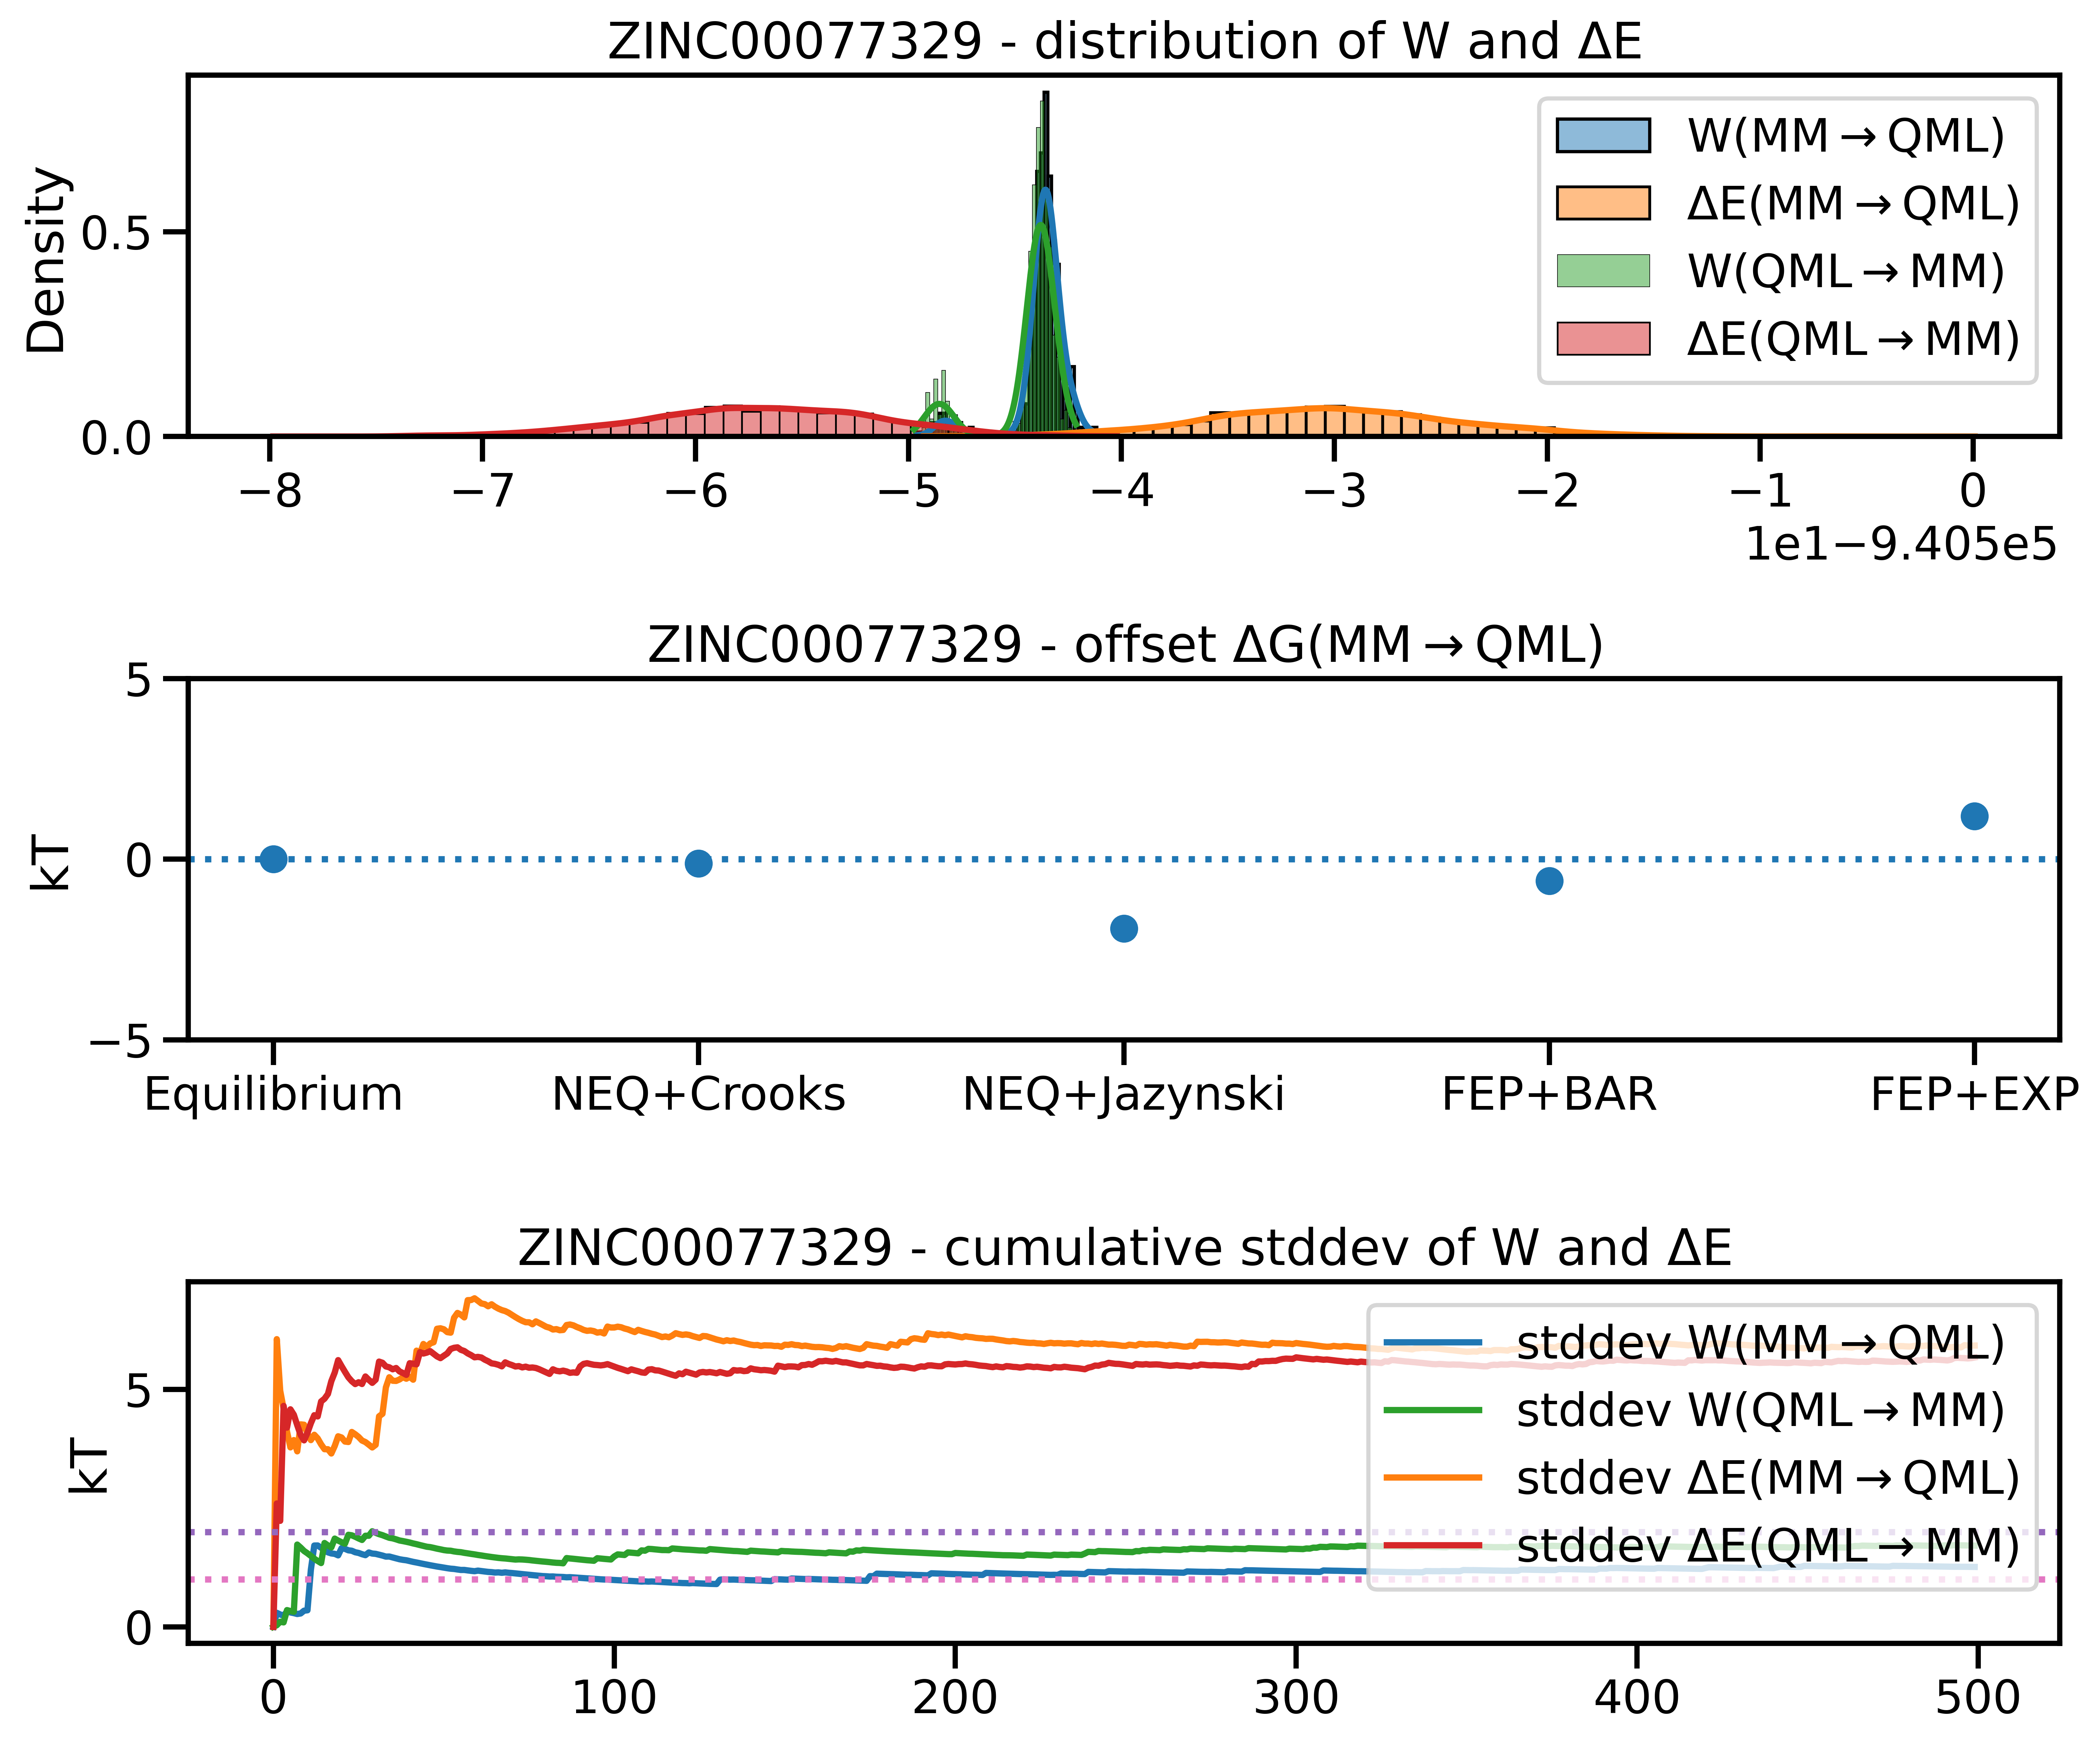

In [2]:
from endstate_correction.analysis import (
    plot_overlap_for_equilibrium_free_energy,
    plot_results_for_equilibrium_free_energy,
)
from endstate_correction.equ import calculate_u_kn
import pathlib
import endstate_correction
from endstate_correction.system import create_charmm_system
from openmm.app import CharmmParameterSet, CharmmPsfFile, CharmmCrdFile
import glob, pickle
import numpy as np
from openmm import unit
import mdtraj as md
from endstate_correction.utils import convert_pickle_to_dcd_file
from endstate_correction.constant import kBT
from pymbar import mbar
from endstate_correction.protocol import Results, Protocol, perform_endstate_correction
from endstate_correction.analysis import plot_endstate_correction_results
import pickle

def load_equ_samples(
    system_name: str, base:str, nr_of_samples: int = 5_000, nr_of_steps: int = 1_000, run_id:int = 1
)->list:
    """Helper function that loads trajectories from the test data"""

    trajs = []
    path = f"{base}/{system_name}/sampling_charmmff/run{run_id:02d}/"

    for lamb in np.linspace(0, 1, 11):
        file = glob.glob(
            f"{path}/{system_name}_samples_{nr_of_samples}_steps_{nr_of_steps}_lamb_{lamb:.4f}.dcd"
        )
        if len(file) == 2:
            raise RuntimeError("Multiple traj files present. Abort.")
        if len(file) == 0:
            raise RuntimeError(
                "WARNING! Incomplete equ sampling. Proceed with cautions."
            )

        trajs.append(md.open(file[0]).read()[0] * unit.angstrom)
    return trajs

def convert_pickle_files(system_name: str, base:str, path_to_psf:str, path_to_crd:str, nr_of_samples: int = 5_000, nr_of_steps: int = 1_000, run_id:int=1):
    """Helper function that converts pickle to dcd files"""
    path = f"{base}/{system_name}/sampling_charmmff/run{run_id:02d}/"

    for lamb in np.linspace(0, 1, 11):
        file = glob.glob(
            f"{path}/{system_name}_samples_{nr_of_samples}_steps_{nr_of_steps}_lamb_{lamb:.4f}.pickle"
        )
        if file[0]:
            dcd_output_path = f"{path}/{system_name}_samples_{nr_of_samples}_steps_{nr_of_steps}_lamb_{lamb:.4f}.dcd"
            pdb_output_path = f"{path}/{system_name}.pdb"
            convert_pickle_to_dcd_file(file[0], path_to_psf, path_to_crd, dcd_output_path, pdb_output_path)

########################################################
########################################################
# ----------------- vacuum -----------------------------
# get all relevant files
path = pathlib.Path(endstate_correction.__file__).resolve().parent
hipen_testsystem = f"{path}/data/hipen_data"

system_name = "ZINC00077329"
path_to_psf = f"{hipen_testsystem}/{system_name}/{system_name}.psf"
path_to_crd = f"{hipen_testsystem}/{system_name}/{system_name}.crd"
psf = CharmmPsfFile(path_to_psf)
coord = CharmmCrdFile(path_to_crd)
params = CharmmParameterSet(
    f"{hipen_testsystem}/top_all36_cgenff.rtf",
    f"{hipen_testsystem}/par_all36_cgenff.prm",
    f"{hipen_testsystem}/{system_name}/{system_name}.str",
)
# define region that should be treated with the qml
chains = list(psf.topology.chains())
ml_atoms = [atom.index for atom in chains[0].atoms()]
# create openmm simulation system
sim = create_charmm_system(
    psf=psf, parameters=params, env="vacuum", ml_atoms=ml_atoms
)

# convert pickle files if necessary
print('converting pickle file ...')
convert_pickle_files(system_name, '/data/shared/projects/endstate_rew', path_to_psf, path_to_crd)
# load all trajectories
trajs = load_equ_samples(system_name, '/data/shared/projects/endstate_rew')
# calculate input for MBAR
N_k, u_kn = calculate_u_kn(
    trajs=trajs,
    every_nth_frame=10,
    sim=sim,
)

# calculate equilibrium free energy difference
print('#-----------------------------------------#')
m = mbar.MBAR(u_kn, N_k)
print(f'Free energy difference: {m.compute_free_energy_differences()["Delta_f"][0][-1]}')
print(f'Free energy uncertainty: {m.compute_free_energy_differences()["dDelta_f"][0][-1]}')
print('#-----------------------------------------#')


# load all trajectories
mm_trajs = []
qml_trajs = []
for i in [1,2,3]:
    # convert pickle files if necessary
    convert_pickle_files(system_name, '/data/shared/projects/endstate_rew', path_to_psf, path_to_crd, run_id = i)
    trajs = load_equ_samples(system_name, '/data/shared/projects/endstate_rew', run_id = i)
    mm_trajs.extend(trajs[0])
    qml_trajs.extend(trajs[-1])

# perform FEP
fep_protocol = Protocol(
    method="FEP",
    direction="bidirectional",
    sim=sim,
    trajectories=[mm_trajs, qml_trajs],
    nr_of_switches=5_000,
)
r = perform_endstate_correction(fep_protocol)

# load NEQ results
r.W_mm_to_qml = pickle.load(open(f'/data/shared/projects/endstate_rew/{system_name}/switching_charmmff/{system_name}_neq_ws_from_mm_to_qml_500_5001.pickle', 'rb')) /kBT
r.W_qml_to_mm = pickle.load(open(f'/data/shared/projects/endstate_rew/{system_name}/switching_charmmff/{system_name}_neq_ws_from_qml_to_mm_500_5001.pickle', 'rb')) /kBT
# put mbar in results object
r.equ_mbar = mbar.MBAR(u_kn, N_k)

plot_endstate_correction_results(
    system_name, r, f"{system_name}_results.png"
)
